In [1]:
# !pip install -q git+git://github.com/quantumjot/BayesianTracker.git
!pip install -q git+git://github.com/quantumjot/cellx.git

!pip install umap-learn

In [2]:
import numpy as np
import random as rand
# if error message: re-run one more time 
# (seems to produce an error on every 1st run but not on the 2nd)
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.applications import ResNet50
#from btrack.dataio import HDF5FileHandler
#from cellx.tools.projection import ManifoldProjection2D as MyManifoldProjection2D
import tifffile as tiff
import glob
import os
from tqdm import tqdm
from skimage.transform import resize
# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
# image normalization for resnet inference
def normalize_image_array(img):
    img_mean = np.mean(img)
    img_stddev = max(np.std(img), 1.0/np.size(img))
    img = np.subtract(img, img_mean)
    img = np.divide(img, img_stddev)
    # clip to 4 standard deviations
    img = np.clip(img, -4, 4)
    return img

In [4]:
# resnet input: needs 3 channels
INPUT_SHAPE = (32,32, 3)

In [5]:
# get pre-trained resnet
model = ResNet50(
    include_top=False, # exclude final fully-connected layer
    weights="imagenet",
    input_shape=INPUT_SHAPE,
)

In [6]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [7]:
### extract many many images from zip file
# from zipfile import ZipFile

# # specifying the zip file name
# zip_file = glob.glob('/content/drive/MyDrive/phd/colab_data/*.zip')[0]
# print(zip_file)
# # opening the zip file in READ mode
# with ZipFile(zip_file, 'r') as zip:
#     # printing all the contents of the zip file
#     #zip.printdir()
  
#     # extracting all the files
#     print('Extracting all the files now...')
#     zip.extractall('/content/drive/MyDrive/phd/colab_data/pcna_glimpses_non_edge/')
#     print('Done!')

In [8]:
# load a series of test files as .npy arrays ## took 3-4 min for 628 images, need to streamline this to handle 175,000
files = glob.glob('/media/nathan/Transcend/Nathan/data/kraken/pcna/MK0000/glimpses/non_edge/non_edge_masked/*.tif')
stack, flat_stack = [], []
N = 8000#len(files)
for i, file in tqdm(enumerate(files)):
    if i < N:
        tif = np.array(tiff.imread(file),dtype=np.uint8)
        tif = resize(tif, (32,32))
        stack.append(tif)
imgs = np.stack(stack, axis = 0)
#flat_imgs = np.stack(flat_stack, axis = 0)
imgs.shape#, flat_imgs.shape

90306it [00:50, 1789.95it/s]


(8000, 32, 32)

In [9]:
## getting rid of stack to save memory?
stack = []

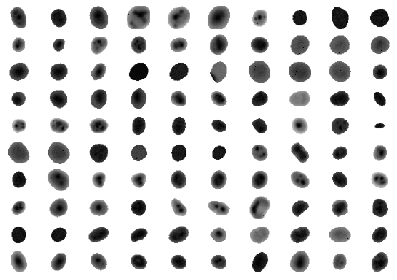

In [10]:
fig, ax_array = plt.subplots(10, 10)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(imgs[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

In [11]:
imgs.shape

(8000, 32, 32)

In [12]:
# transform single-channel to 3-channel for resnet & umap
imgs = np.repeat(imgs[..., np.newaxis], 3, axis=-1)
imgs.shape

(8000, 32, 32, 3)

In [13]:
# get test labels ### not for mnist example data
labels, coarse_labels = [], []
for j, i in enumerate(files):
  if j < N:
    label = float((i.split('age')[1]).split('.tif')[0]) 
    labels.append(label)
    if label < 0.34:
      coarse_label = 0
    elif label <0.67:
      coarse_label = 0.5
    else:
      coarse_label = 1
    coarse_labels.append(coarse_label)
print(len(labels))
print(labels)

8000
[0.285, 0.264, 0.824, 0.933, 0.634, 0.522, 0.164, 0.567, 0.412, 0.731, 0.079, 0.014, 0.761, 0.383, 0.011, 0.862, 0.586, 0.966, 0.786, 0.469, 0.673, 0.467, 0.424, 0.829, 0.738, 0.549, 0.986, 0.7, 0.671, 0.553, 0.543, 0.147, 0.117, 0.1, 0.152, 0.614, 0.636, 0.751, 0.292, 0.014, 0.883, 0.453, 0.364, 0.945, 0.832, 0.214, 0.988, 0.905, 0.819, 0.005, 0.635, 0.626, 0.738, 0.831, 0.756, 0.178, 0.129, 0.508, 0.486, 0.198, 0.597, 0.603, 0.172, 0.145, 0.005, 0.517, 0.507, 0.735, 0.379, 0.945, 0.7, 0.516, 0.308, 0.51, 0.698, 0.48, 0.882, 0.063, 0.392, 0.89, 0.797, 0.112, 0.907, 0.692, 0.455, 0.078, 0.714, 0.641, 0.91, 0.414, 0.894, 0.144, 0.659, 0.256, 0.167, 0.045, 0.987, 0.7, 0.236, 0.55, 0.146, 0.43, 0.616, 0.968, 0.793, 0.835, 0.501, 0.557, 0.265, 0.933, 0.535, 0.378, 0.925, 0.848, 0.758, 0.397, 0.057, 0.496, 0.478, 0.365, 0.408, 0.272, 0.189, 0.324, 0.48, 0.213, 0.187, 0.703, 0.932, 0.743, 0.893, 0.548, 0.399, 0.455, 0.798, 0.027, 0.42, 0.955, 0.865, 0.306, 0.445, 0.34, 0.636, 0.493, 0.1

In [14]:
# normalization of images for resnet & convert to float32
imgs = normalize_image_array(imgs.astype(np.float32))
imgs.shape, imgs.dtype

((8000, 32, 32, 3), dtype('float32'))

**extract features with trained resnet**

In [15]:
test_features = model.predict(imgs, batch_size=64)
test_features.shape

(8000, 1, 1, 2048)

**preprocessing for dimensionality reduction**

In [16]:
# reshape model predictions to 2D array
X = test_features.reshape(test_features.shape[0], -1)
#X_gauss = test_features_gauss.reshape(test_features_gauss.shape[0], -1)
X.shape

(8000, 2048)

In [17]:
# standard scaling
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)

In [18]:
# hyperparameters for UMAP/densMAP
nbs = 50
eps = 2000
rnd = 0

In [19]:
# define umap instance with above hyperparameters
mapper = UMAP(n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
mapper.fit(X)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=2000,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 16:25:44 2021 Finding Nearest Neighbors
Tue Jul 20 16:25:44 2021 Building RP forest with 9 trees
Tue Jul 20 16:25:45 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Jul 20 16:25:56 2021 Finished Nearest Neighbor Search
Tue Jul 20 16:25:59 2021 Construct embedding
	completed  0  /  2000 epochs
	completed  200  /  20

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=2000,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)

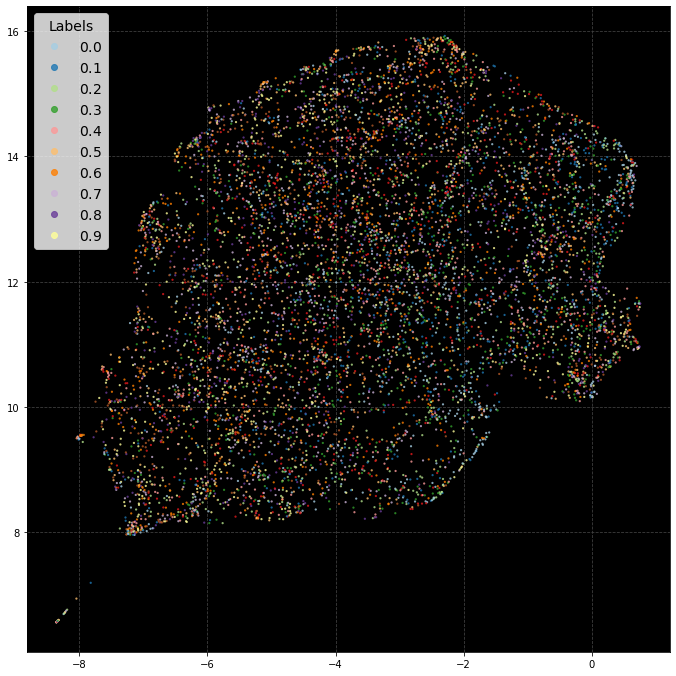

In [21]:
# plot mapper embedding
fig, ax = plt.subplots(figsize=(9.5, 9.5))

scatter = ax.scatter(mapper.embedding_[:, 1], mapper.embedding_[:, 0], c=labels, 
                    #  label=["non-db", "db"], 
                     cmap="Paired", 
                     alpha=0.8, 
                     edgecolors="none", s=5, zorder=1)

# ax.set_title("UMAP embedding", fontsize=18)
# ax.legend()
ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
ax.set_facecolor('k')
ax.set_axisbelow(True)
ax.grid(color="0.25", linestyle="--")

# plt.gca().axes.get_xaxis().set_visible(False)
# plt.gca().axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# fig.savefig(f"/content/drive/MyDrive/PhD/export_data/umap_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

# trying out different hyperparams

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=2000,
     n_neighbors=2, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 16:47:33 2021 Finding Nearest Neighbors
Tue Jul 20 16:47:33 2021 Building RP forest with 9 trees
Tue Jul 20 16:47:34 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
Tue Jul 20 16:47:34 2021 Finished Nearest Neighbor Search
Tue Jul 20 16:47:34 2021 Construct embedding


/home/nathan/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/nathan/anaconda3/lib/python3.7/site-packages/umap/spectral.py:253: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/nathan/anaconda3/lib/python3.7/site-packages/umap/spectral.py:253: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


	completed  0  /  2000 epochs
	completed  200  /  2000 epochs
	completed  400  /  2000 epochs
	completed  600  /  2000 epochs
	completed  800  /  2000 epochs
	completed  1000  /  2000 epochs
	completed  1200  /  2000 epochs
	completed  1400  /  2000 epochs
	completed  1600  /  2000 epochs
	completed  1800  /  2000 epochs
Tue Jul 20 16:55:45 2021 Finished embedding


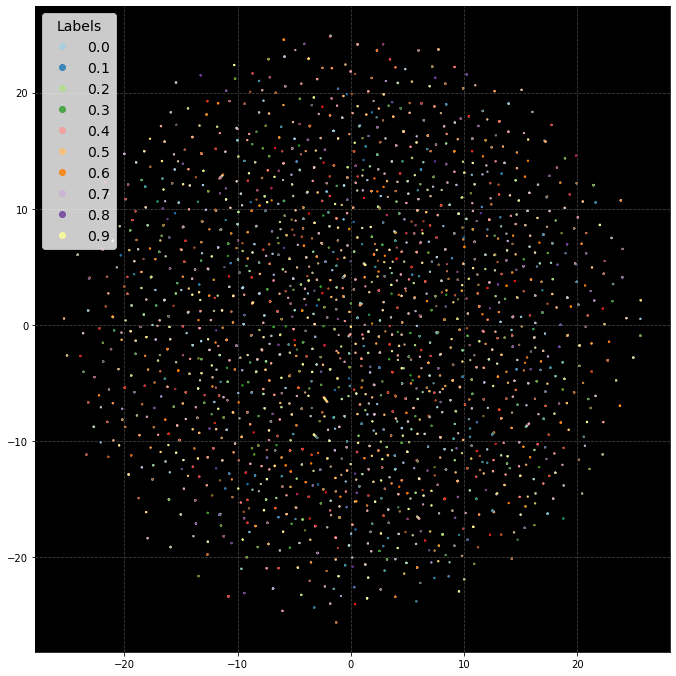

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=4000,
     n_neighbors=22, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 16:55:46 2021 Finding Nearest Neighbors
Tue Jul 20 16:55:46 2021 Building RP forest with 9 trees
Tue Jul 20 16:55:47 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
Tue Jul 20 16:55:50 2021 Finished Nearest Neighbor Search
Tue Jul 20 16:55:50 2021 Construct embedding
	completed  0  /  4

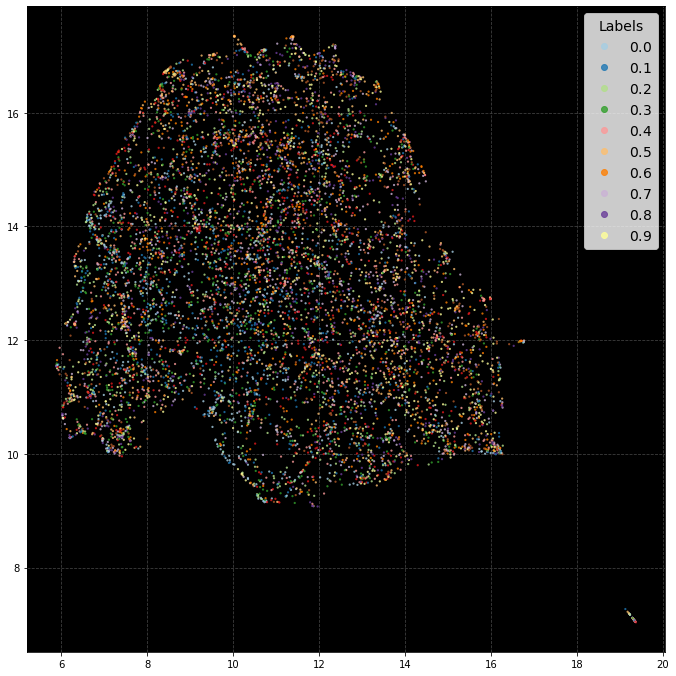

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=6000,
     n_neighbors=42, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 16:57:36 2021 Finding Nearest Neighbors
Tue Jul 20 16:57:36 2021 Building RP forest with 9 trees
Tue Jul 20 16:57:37 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
Tue Jul 20 16:57:41 2021 Finished Nearest Neighbor Search
Tue Jul 20 16:57:42 2021 Construct embedding
	completed  0  /  6000 epochs
	completed 

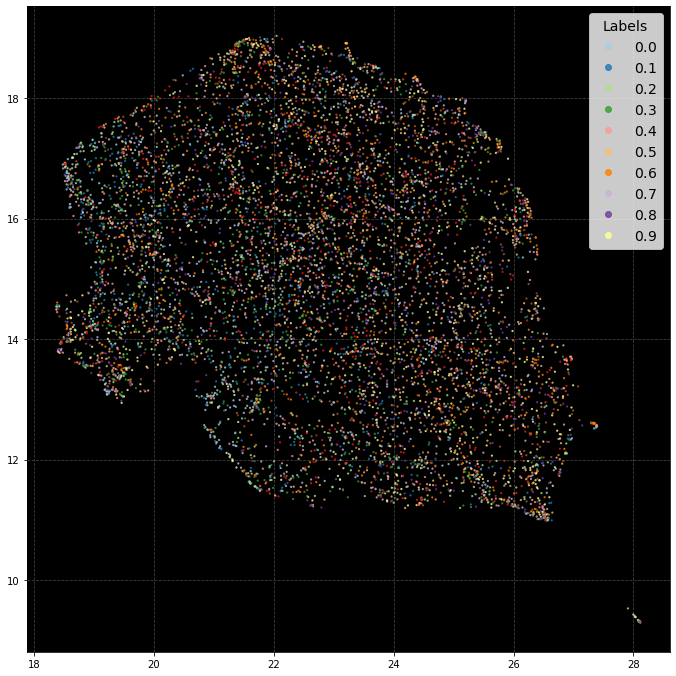

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=8000,
     n_neighbors=62, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 17:01:07 2021 Finding Nearest Neighbors
Tue Jul 20 17:01:07 2021 Building RP forest with 9 trees
Tue Jul 20 17:01:08 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Jul 20 17:01:16 2021 Finished Nearest Neighbor Search
Tue Jul 20 17:01:17 2021 Construct embedding
	completed  0  /  8000 epochs
	completed  800  /  80

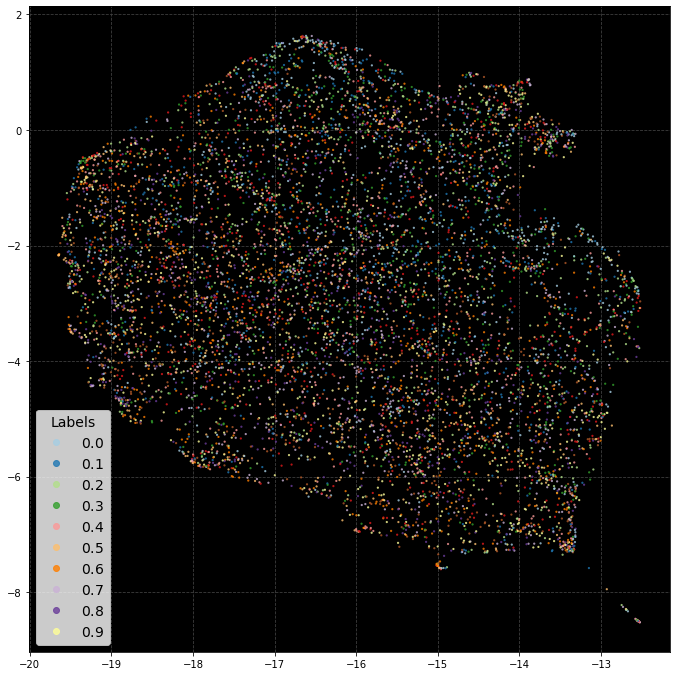

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=10000,
     n_neighbors=82, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 17:06:50 2021 Finding Nearest Neighbors
Tue Jul 20 17:06:50 2021 Building RP forest with 9 trees
Tue Jul 20 17:06:51 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Jul 20 17:07:03 2021 Finished Nearest Neighbor Search
Tue Jul 20 17:07:04 2021 Construct embedding
	completed  0  /  10000 epochs
	completed  1000  / 

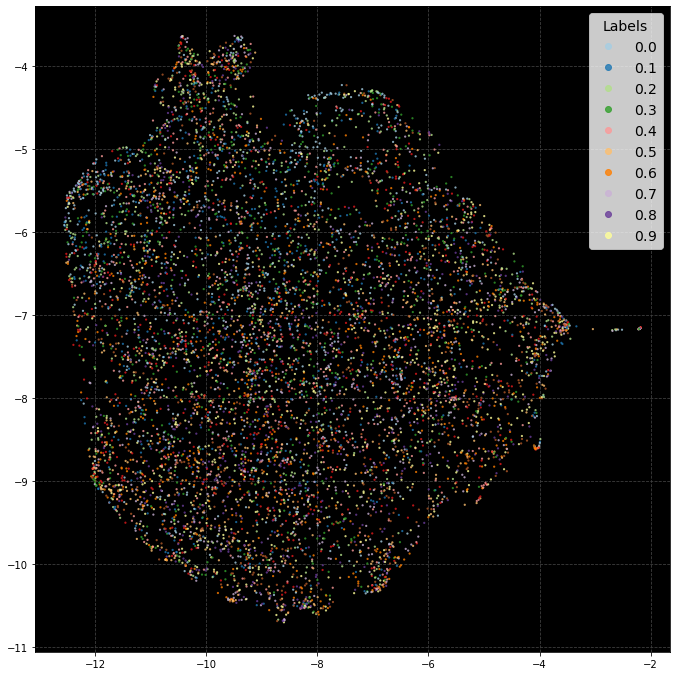

In [27]:
for i in range(0,5):
    nbs = 2+(i*20)
    eps = ((i+1)*2000)
    rnd = 0
    mapper = UMAP(n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
    mapper.fit(X)
    # plot mapper embedding
    fig, ax = plt.subplots(figsize=(9.5, 9.5))

    scatter = ax.scatter(mapper.embedding_[:, 1], mapper.embedding_[:, 0], c=labels, 
                        #  label=["non-db", "db"], 
                         cmap="Paired", 
                         alpha=0.8, 
                         edgecolors="none", s=5, zorder=1)

    ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
    ax.set_facecolor('k')
    ax.set_axisbelow(True)
    ax.grid(color="0.25", linestyle="--")


    plt.tight_layout()
    plt.show()
    fig.savefig('test_nbs{}_eps{}.png'.format(nbs,eps))

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=10000,
     n_neighbors=100, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 17:14:30 2021 Finding Nearest Neighbors
Tue Jul 20 17:14:30 2021 Building RP forest with 9 trees
Tue Jul 20 17:14:31 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Jul 20 17:14:43 2021 Finished Nearest Neighbor Search
Tue Jul 20 17:14:43 2021 Construct embedding
	completed  0  /  10000 epochs
	completed  1000  /

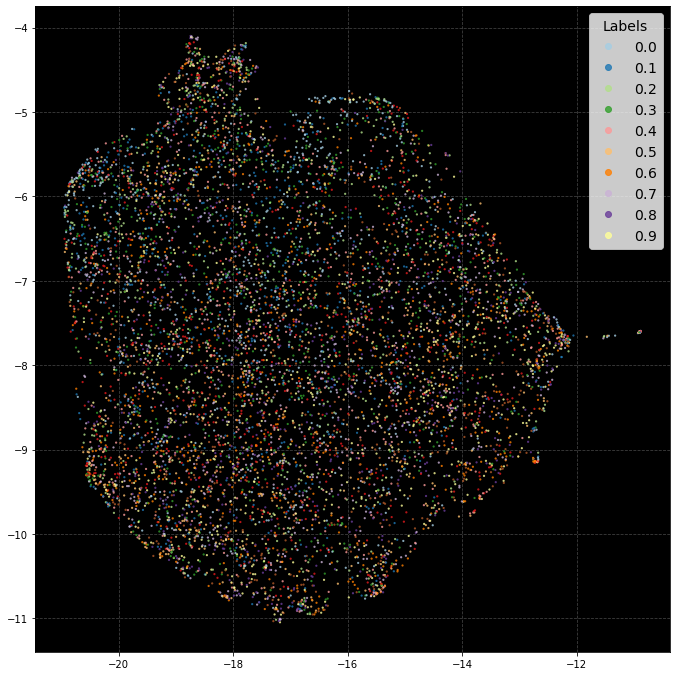

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=10000,
     n_neighbors=150, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 17:22:51 2021 Finding Nearest Neighbors
Tue Jul 20 17:22:51 2021 Building RP forest with 9 trees
Tue Jul 20 17:22:52 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Jul 20 17:23:06 2021 Finished Nearest Neighbor Search
Tue Jul 20 17:23:07 2021 Construct embedding
	completed  0  /  10000 epochs
	completed  1000  /

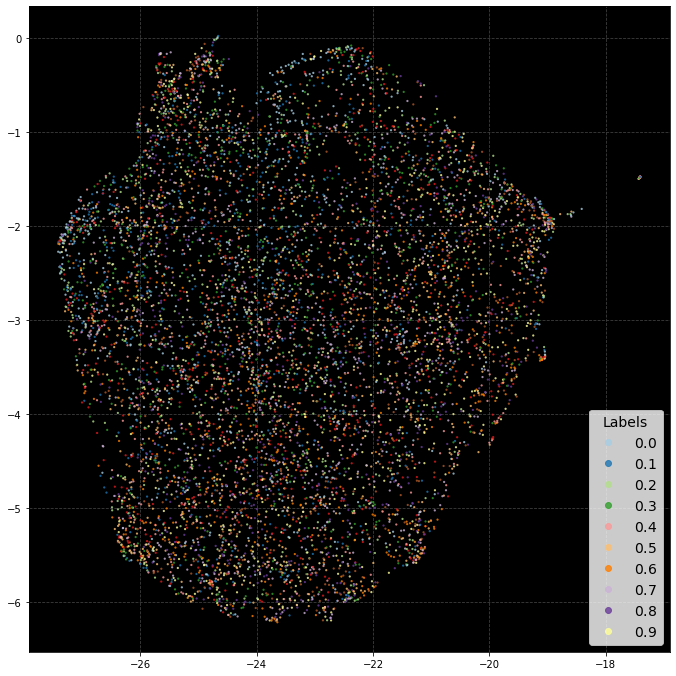

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=10000,
     n_neighbors=200, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 17:30:06 2021 Finding Nearest Neighbors
Tue Jul 20 17:30:06 2021 Building RP forest with 9 trees
Tue Jul 20 17:30:06 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Jul 20 17:30:23 2021 Finished Nearest Neighbor Search
Tue Jul 20 17:30:24 2021 Construct embedding
	completed  0  /  10000 epochs
	completed  1000  /

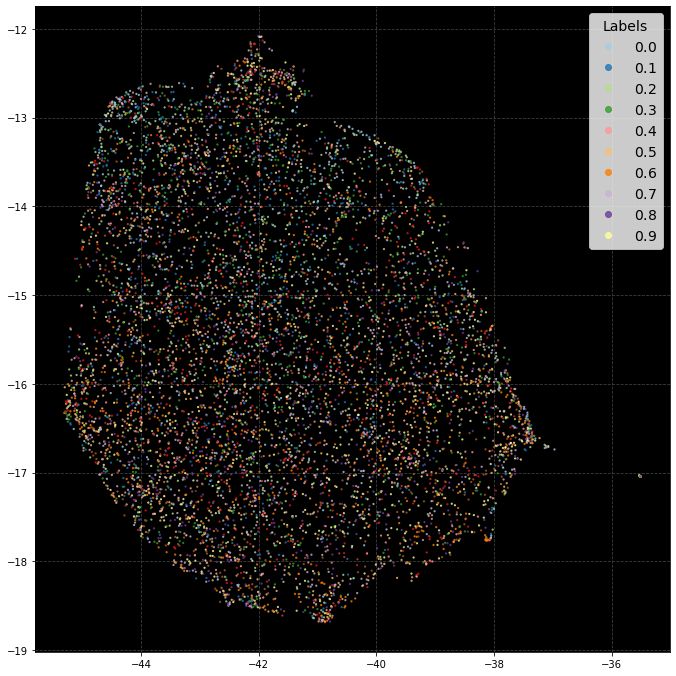

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=10000,
     n_neighbors=250, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 17:37:34 2021 Finding Nearest Neighbors
Tue Jul 20 17:37:34 2021 Building RP forest with 9 trees
Tue Jul 20 17:37:35 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Jul 20 17:37:53 2021 Finished Nearest Neighbor Search
Tue Jul 20 17:37:55 2021 Construct embedding
	completed  0  /  10000 epochs
	completed  1000  /

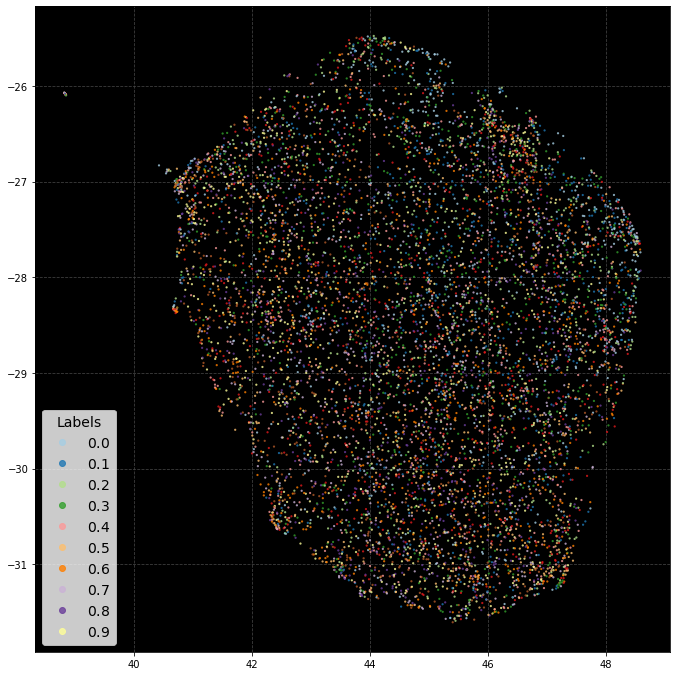

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=10000,
     n_neighbors=300, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 17:45:34 2021 Finding Nearest Neighbors
Tue Jul 20 17:45:34 2021 Building RP forest with 9 trees
Tue Jul 20 17:45:34 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Jul 20 17:45:55 2021 Finished Nearest Neighbor Search
Tue Jul 20 17:45:57 2021 Construct embedding
	completed  0  /  10000 epochs
	completed  1000  /

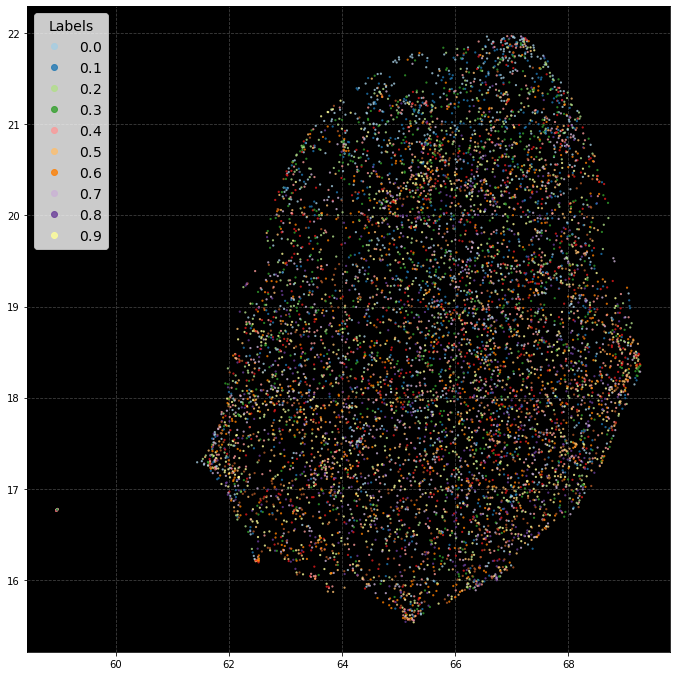

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=10000,
     n_neighbors=350, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 17:54:08 2021 Finding Nearest Neighbors
Tue Jul 20 17:54:08 2021 Building RP forest with 9 trees
Tue Jul 20 17:54:08 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Jul 20 17:54:31 2021 Finished Nearest Neighbor Search
Tue Jul 20 17:54:33 2021 Construct embedding
	completed  0  /  10000 epochs
	completed  1000  /

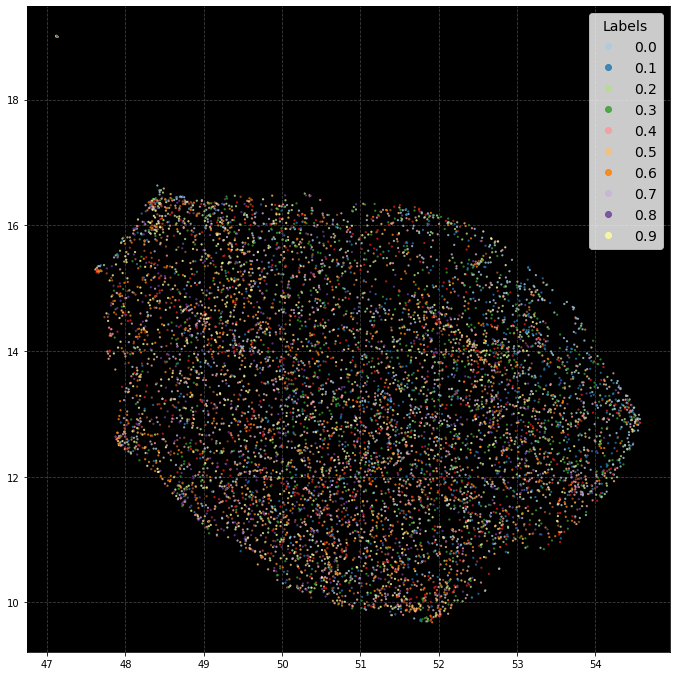

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=10000,
     n_neighbors=400, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 18:03:39 2021 Finding Nearest Neighbors
Tue Jul 20 18:03:39 2021 Building RP forest with 9 trees
Tue Jul 20 18:03:40 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Jul 20 18:04:05 2021 Finished Nearest Neighbor Search
Tue Jul 20 18:04:07 2021 Construct embedding
	completed  0  /  10000 epochs
	completed  1000  /

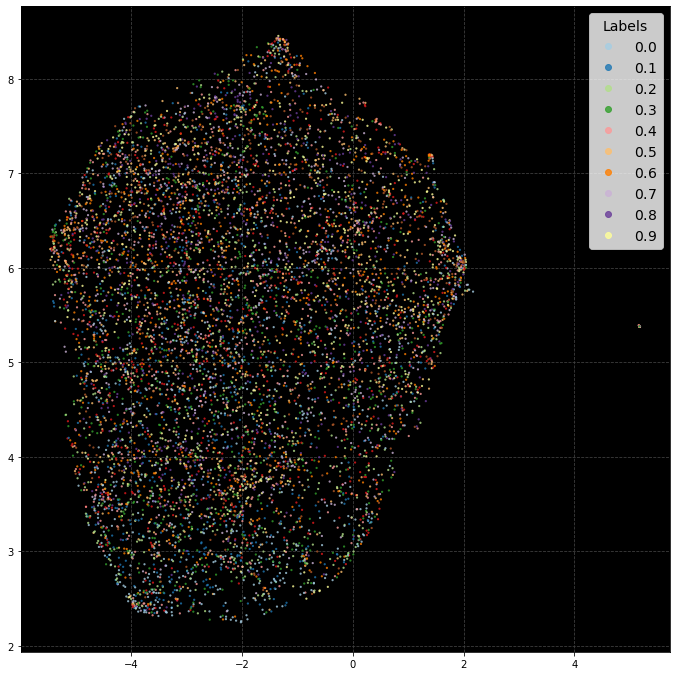

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=10000,
     n_neighbors=450, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 18:13:19 2021 Finding Nearest Neighbors
Tue Jul 20 18:13:19 2021 Building RP forest with 9 trees
Tue Jul 20 18:13:19 2021 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Tue Jul 20 18:13:46 2021 Finished Nearest Neighbor Search
Tue Jul 20 18:13:49 2021 Construct embedding
	completed  0  /  10000 epochs
	completed  1000  /

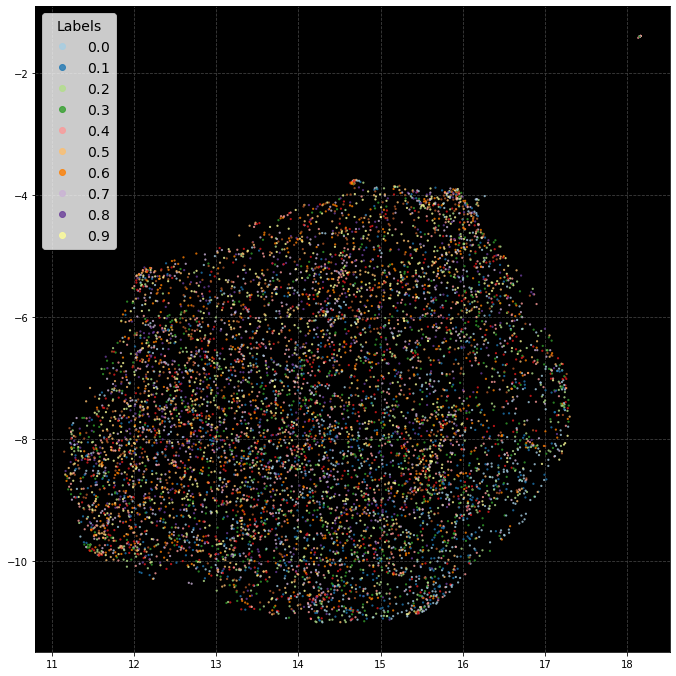

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=10000,
     n_neighbors=500, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Tue Jul 20 18:23:29 2021 Finding Nearest Neighbors
Tue Jul 20 18:23:29 2021 Building RP forest with 9 trees
Tue Jul 20 18:23:29 2021 NN descent for 13 iterations
	 0  /  13
	

In [ ]:
for i in range(0,10):
    nbs = (i+2)*50
    eps = 10000
    rnd = 0
    mapper = UMAP(n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
    mapper.fit(X)
    # plot mapper embedding
    fig, ax = plt.subplots(figsize=(9.5, 9.5))

    scatter = ax.scatter(mapper.embedding_[:, 1], mapper.embedding_[:, 0], c=labels, 
                        #  label=["non-db", "db"], 
                         cmap="Paired", 
                         alpha=0.8, 
                         edgecolors="none", s=5, zorder=1)

    ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
    ax.set_facecolor('k')
    ax.set_axisbelow(True)
    ax.grid(color="0.25", linestyle="--")


    plt.tight_layout()
    plt.show()
    fig.savefig('test_nbs{}_eps{}.png'.format(nbs,eps))

In [ ]:
stop

In [ ]:
# define densmap instance (takes in a local density parameter) with above hyperparameters
dens_mapper = UMAP(densmap=True, n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
dens_mapper.fit(X)

In [ ]:
# plot densmapper embedding
fig, ax = plt.subplots(figsize=(9.5, 9.5))

scatter = ax.scatter(dens_mapper.embedding_[:, 1], dens_mapper.embedding_[:, 0], c=test_labels, 
                    #  label=["non-db", "db"], 
                     cmap="Paired", 
                     alpha=0.8, 
                     edgecolors="none", s=5, zorder=1)

# ax.set_title("UMAP embedding", fontsize=18)
# ax.legend()
ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
ax.set_facecolor('k')
ax.set_axisbelow(True)
ax.grid(color="0.25", linestyle="--")

# plt.gca().axes.get_xaxis().set_visible(False)
# plt.gca().axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# fig.savefig(f"{export_path}umap_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

plotting with coarse labels

In [ ]:
# plot mapper embedding
fig, ax = plt.subplots(figsize=(9.5, 9.5))

scatter = ax.scatter(mapper.embedding_[:, 1], mapper.embedding_[:, 0], c=coarse_labels, 
                    #  label=["non-db", "db"], 
                     cmap="Paired", 
                     alpha=0.8, 
                     edgecolors="none", s=25, zorder=1)

# ax.set_title("UMAP embedding", fontsize=18)
# ax.legend()
ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
ax.set_facecolor('k')
ax.set_axisbelow(True)
ax.grid(color="0.25", linestyle="--")

# plt.gca().axes.get_xaxis().set_visible(False)
# plt.gca().axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# fig.savefig(f"/content/drive/MyDrive/PhD/export_data/umap_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

In [ ]:
# plot densmapper embedding
fig, ax = plt.subplots(figsize=(9.5, 9.5))

scatter = ax.scatter(dens_mapper.embedding_[:, 1], dens_mapper.embedding_[:, 0], c=coarse_labels, 
                    #  label=["non-db", "db"], 
                     cmap="Paired", 
                     alpha=0.8, 
                     edgecolors="none", s=25, zorder=1)

# ax.set_title("UMAP embedding", fontsize=18)
# ax.legend()
ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
ax.set_facecolor('k')
ax.set_axisbelow(True)
ax.grid(color="0.25", linestyle="--")

# plt.gca().axes.get_xaxis().set_visible(False)
# plt.gca().axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# fig.savefig(f"{export_path}umap_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

trying different hyperparameters

In [ ]:
# hyperparameters for UMAP/densMAP
nbs = 5
eps = 200000
rnd = 0
# define umap instance with above hyperparameters
mapper = UMAP(n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
mapper.fit(X)
fig, ax = plt.subplots(figsize=(9.5, 9.5))

scatter = ax.scatter(mapper.embedding_[:, 1], mapper.embedding_[:, 0], c=test_labels, 
                    #  label=["non-db", "db"], 
                     cmap="Paired", 
                     alpha=0.8, 
                     edgecolors="none", s=50, zorder=1)

ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
ax.set_facecolor('k')
ax.set_axisbelow(True)
ax.grid(color="0.25", linestyle="--")

plt.tight_layout()
plt.show()


**superimposing binned images on embedding (like a 2D histogram)**
- in the `MyManifoldProjection` function, you can choose between showing an average image of the bin or showing a single image

In [ ]:
# normalize image values to 0-1 range (Min-Max scaling) & 
# convert to 8-bit for projection on umap
embed_imgs = ((imgs-np.min(imgs))/(np.ptp(imgs)) * 255).astype(np.uint8)
print(embed_imgs.shape)

In [ ]:
# define ManifoldProjection instance with specified output shape (default = 64x64)
mapper_projection = MyManifoldProjection2D(embed_imgs, output_shape=(32,32))

In [ ]:
# get image grid, increase bin number to show more images/granularity
img_grid, heatmap, delimiters = mapper_projection(mapper.embedding_, components=(0,1), bins=16)
img_grid_dens, heatmap_dens, delimiters_dens = mapper_projection(dens_mapper.embedding_, components=(0,1), bins=16)

In [ ]:
# plot mapper image projection

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12, 9.5))

im = plt.imshow(img_grid,
                origin="lower",
                # extent=delimiters, 
                #vmin=0, vmax=255, # modify or comment out according to image intensity values to show
                cmap="gray",)

# scatter plot will only show appropriately if `extent` is used in imshow
# scatter = ax.scatter(mapper.embedding_[:, 1], mapper.embedding_[:, 0], c=test_labels, 
#                     #  label=["non-db", "db"], 
#                      cmap="Paired", 
#                     #  alpha=0.3, 
#                      edgecolors="none", 
#                      s=3, 
#                      zorder=2)

plt.axis("off")
plt.tight_layout()
plt.colorbar()
#plt.savefig('/content/drive/MyDrive/phd/colab_data/UMAP_attempt.png', dpi=300, bbox_inches="tight")
#fig.savefig('/content/drive/MyDrive/phd/colab_data/UMAP_attempt.png', dpi=300, bbox_inches="tight")

In [ ]:
# plot densmapper image projection

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12, 9.5))

im = plt.imshow(img_grid_dens,
                origin="lower",
                # extent=delimiters, 
                vmin=100, vmax=140, # modify or comment out according to image intensities
                cmap="gray",)

# scatter plot will only show appropriately if `extent` is used in imshow
# scatter = ax.scatter(mapper_dens.embedding_[:, 1], mapper_dens.embedding_[:, 0], c=test_labels, 
#                     #  label=["non-db", "db"], 
#                      cmap="Paired", 
#                     #  alpha=0.3, 
#                      edgecolors="none", 
#                      s=3, 
#                      zorder=2)

plt.axis("off")
plt.tight_layout()
plt.colorbar()

# fig.savefig(f"{output_path}umap_dens_masked_32bins_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

In [ ]:
# # personalized
# from scipy.stats import binned_statistic_2d
# from skimage.io import imread
# from skimage.transform import resize
# from tqdm import tqdm

# def _load_and_normalize(filename: str, output_shape: tuple = (64, 64)):
#     """Load an image, reshape to output_shape and normalize."""

#     # reshape to a certain image size
#     image = resize(imread(filename), output_shape, preserve_range=True)
#     n_pixels = np.prod(output_shape)
#     n_channels = image.shape[-1]
#     print(f"channels: {n_channels}")

#     a_std = lambda d: np.max([np.std(d), 1.0 / np.sqrt(n_pixels)])
#     nrm = lambda d: np.clip((d - np.mean(d)) / a_std(d), -4.0, 4.0)

#     for dim in range(n_channels):
#         image[..., dim] = nrm(image[..., dim])

#     # TODO(arl): ????
#     image = np.clip(255.0 * ((image + 1.0) / 5.0), 0, 255)
#     return image

# """
# class MyManifoldProjection2D:
#     """ManifoldProjection2D.

#     Make a montage of image patches that represent examples from a manifold
#     projection.

#     Parameters
#     ----------
#     images : list of str or (N, W, H, C) np.ndarray
#         A list of image filenames or a numpy array of N images, width W, height
#         H, and C channels.
#     output_shape : tuple of int
#         Final size to reshape individual image patches to for the montage.
#     preload_images : bool
#         Preload images if a list of image filenames is provided, or not.
#     """

#     def __init__(
#         self, images: list, output_shape: tuple = (64, 64), preload_images: bool = True,
#     ):

#         self._output_shape = output_shape
#         self._images = None

#         # check if `images` parameter is a list of strings or a numpy array
#         # to preload images, or not
#         if all([isinstance(img, str) for img in images]):
#             if preload_images:
#                 self._images = [self._get_image(file) for file in tqdm(images)]
#         else:
#             if not isinstance(images, np.ndarray):
#                 raise ValueError("Image type unknown.")
#             self._images = images

#     def _get_image(self, filename: str) -> np.ndarray:
#         """Grab an image and resize it."""
#         return _load_and_normalize(filename, output_shape=self._output_shape)

#     def __call__(
#         self, manifold: np.ndarray, bins: int = 32, components: tuple = (0, 1)
#     ) -> tuple:
#         """Build the projection.

#         Parameters
#         ----------
#         manifold : np.ndarray
#             Numpy array of the manifold projection.
#         bins : int
#             Number of two-dimensional bins to group the manifold examples in.
#         components : tuple of int
#             Dimensions of manifold to use when creating the projection.

#         Returns
#         -------
#         imgrid : np.ndarray
#             An image with example image patches from the manifold arranged on a
#             grid.
#         extent : tuple
#             Delimits the minimum and maximum bin edges, in each dimension, used
#             to create the result.
#         """

#         assert manifold.shape[0] == len(self._images)

#         # bin the manifold
#         counts, xe, ye, bn = binned_statistic_2d(
#             manifold[:, components[0]],
#             manifold[:, components[1]],
#             [],
#             bins=bins,
#             statistic="count",
#             expand_binnumbers=True,
#         )

#         bxy = zip(bn[0, :].tolist(), bn[1, :].tolist())

#         # make a lookup dictionary
#         grid = {}
#         for idx, b in enumerate(bxy):
#             if b not in grid:
#                 grid[b] = []

#             if self._images is not None:
#                 grid[b].append(self._images[idx])
#             else:
#                 if not grid[b]:
#                     grid[b].append(self._get_image(self._image_files[idx]))

#         # now make the grid image
#         full_bins = [int(b) for b in self._output_shape]
#         half_bins = [b // 2 for b in self._output_shape]
#         imgrid = np.zeros(
#             (
#                 (full_bins[0] + 1) * bins + half_bins[0],
#                 (full_bins[1] + 1) * bins + half_bins[1],
#                 3,
#             ),
#             dtype="uint16",
#         )
#         # build it
#         for e, (xy, images) in enumerate(tqdm(grid.items())):
#             stack = np.stack(images, axis=0)
#             # get average of each stack of images -> average image generated
#             # im = np.mean(stack, axis=0)
#             # get random single image from stack
#             rand.seed(e)
#             rnd_pos = rand.randint(0, len(stack)-1)
#             im = stack[rnd_pos, ...]

#             xx, yy = xy
#             blockx = slice(
#                 xx * full_bins[0] - half_bins[0],
#                 xx * full_bins[0] - half_bins[0] + self._output_shape[0],
#                 1,
#             )
#             blocky = slice(
#                 yy * full_bins[1] - half_bins[1],
#                 yy * full_bins[1] - half_bins[1] + self._output_shape[1],
#                 1,
#             )

#             try:
#                 imgrid[blockx, blocky] = im
#             except:
#                 raise ValueError("`imgrid` error")
#                 pass
            
#         # switch `xe` and `ye` around to get the right xy axes on the projection 
#         extent = (min(ye), max(ye), min(xe), max(xe))
#         print(extent)

#         return imgrid, counts, extent
# """